# RNN Implementation and Experiments

This notebook demonstrates the RNN implementation and experiments. We'll work with the NusaX-Sentiment dataset to perform text classification.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense, Bidirectional
from sklearn.metrics import f1_score, classification_report

2025-05-30 15:59:47.330087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748595587.371691   94333 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748595587.381481   94333 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748595587.436968   94333 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748595587.437056   94333 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748595587.437061   94333 computation_placer.cc:177] computation placer alr

In [3]:
from src.models.src.models.base_model.utils.nusax_loader import NusaXLoader
from src.models.src.models.rnn.experiment import RNNExperiments
from src.models.src.models.rnn.rnn_model import RNNModel
from src.models.src.models.rnn.rnn_layer import RNNLayer
from src.models.src.models.base_model.layers.embedding_layer import EmbeddingLayer
from src.models.src.models.base_model.layers.dense_layer import DenseLayer
from src.models.src.models.base_model.layers.dropout_layer import DropoutLayer
from src.models.src.models.base_model.layers.activation_layer import Softmax
from src.models.src.models.base_model.utils.evaluation import compare_keras_vs_scratch
from src.models.src.models.base_model.utils.visualization import plot_training_history

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Num GPUs Available: {len(gpus)}")
        print(f"Num Logical GPUs: {len(logical_gpus)}")
    except RuntimeError as e:
        print(e)


Num GPUs Available: 1
Num Logical GPUs: 1


I0000 00:00:1748595595.434827   94333 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## 1. Load Data

In [5]:
# Init data loader
data_loader = NusaXLoader(batch_size=32, add=True)
# Ini add buat ngubah pathnya nambah "../" tapi harusnya gaperlu soalnya di file siblingnsnya juga gapake ini, api entah kenapa gabisa jalan kalo gadipasang

# Train
train_dataset = data_loader.get_dataset('train')
for tokens, labels in train_dataset.take(1):
    sample_tokens = tokens.numpy()
    sample_labels = labels.numpy()
    break

# Get vocabulary
vocab = data_loader.get_vocabulary()
print(f"Vocabulary size: {len(vocab)}")
print(f"First 20 words in vocabulary: {vocab[:20]}")

# Output Example
print("\nSample texts:")
for i in range(3):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_tokens[i] if idx > 0]
    text = " ".join(words)
    print(f"Text {i+1}: {text}")
    print(f"Label: {sample_labels[i]}\n")

Vocabulary size: 2836
First 20 words in vocabulary: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini'), np.str_('makan'), np.str_('untuk'), np.str_('ke'), np.str_('tempat'), np.str_('makanan'), np.str_('juga'), np.str_('sangat'), np.str_('ada'), np.str_('banyak'), np.str_('karena')]

Sample texts:
Text 1: nikmati cicilan 0 hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni
Label: 1

Text 2: kuekue yang disajikan bikin saya bernostalgia semuanya tipikal kue zaman dulu baik dari penampilan maupun rasa kuenya enak dan harganya juga murah
Label: 2

Text 3: ibu pernah bekerja di grab indonesia
Label: 1



## 2. Hyperparameter Experiments with RNN

In [6]:
experiments = RNNExperiments(data_loader=data_loader, batch_size=32, epochs=10, embedding_dim=100)

Vocabulary size: 2836
Number of classes: 3
Maximum sequence length: 100
Batch size: 32
Epochs: 10
Embedding dimension: 100


### 2.1 Experiment: Number of RNN Layers


=== Training model with 1 RNN Layer ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.3917 - loss: 1.1139 - val_accuracy: 0.3800 - val_loss: 1.0845
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4087 - loss: 1.0671 - val_accuracy: 0.4000 - val_loss: 1.1080
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6624 - loss: 0.8063 - val_accuracy: 0.3700 - val_loss: 1.6243
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6670 - loss: 0.8517 - val_accuracy: 0.4400 - val_loss: 1.2754
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6363 - loss: 0.8461 - val_accuracy: 0.3300 - val_loss: 1.1636
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5583 - loss: 0.8447 - val_accuracy: 0.4300 - val_loss: 1.1160
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6401 - loss: 0.8532 - val_accuracy: 0.4600 - val_loss: 1.2683
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6540 - loss: 0.8723 - val_accuracy: 0.4700 - val_loss: 1

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_22 (SimpleRNN)       │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,067 (3.37 MB)

 Trainable params: 294,355 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,712 (2.25 MB)


=== Training model with 2 RNN Layers ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.3443 - loss: 1.1439 - val_accuracy: 0.3800 - val_loss: 1.1258
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3651 - loss: 1.1256 - val_accuracy: 0.2900 - val_loss: 1.1638
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5693 - loss: 0.9513 - val_accuracy: 0.3700 - val_loss: 1.2781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7061 - loss: 0.6906 - val_accuracy: 0.4100 - val_loss: 1.4100
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7612 - loss: 0.5765 - val_accuracy: 0.3300 - val_loss: 1.6183
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7791 - loss: 0.5719 - val_accuracy: 0.3700 - val_loss: 1.5913
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9122 - loss: 0.2542 - val_accuracy: 0.3900 - val_loss: 1.8860
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9707 - loss: 0.1043 - val_accuracy: 0.3700 - val_loss: 2

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_23 (SimpleRNN)       │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_24 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,835 (3.46 MB)

 Trainable params: 302,611 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 605,224 (2.31 MB)


=== Training model with 3 RNN Layers ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 485ms/step - accuracy: 0.4248 - loss: 1.1501 - val_accuracy: 0.4900 - val_loss: 1.0792
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4361 - loss: 1.0634 - val_accuracy: 0.4000 - val_loss: 1.1486
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5574 - loss: 0.9624 - val_accuracy: 0.4000 - val_loss: 1.2845
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5394 - loss: 0.9730 - val_accuracy: 0.4000 - val_loss: 1.3747
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4280 - loss: 1.1949 - val_accuracy: 0.2900 - val_loss: 1.8524
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2563 - loss: 1.7381 - val_accuracy: 0.3700 - val_loss: 1.0912
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3562 - loss: 1.1665 - val_accuracy: 0.3800 - val_loss: 1.0985
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2897 - loss: 1.2056 - val_accuracy: 0.4300 - val_loss: 

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_25 (SimpleRNN)       │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_26 (SimpleRNN)       │ (None, 100, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_27 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 932,603 (3.56 MB)

 Trainable params: 310,867 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 621,736 (2.37 MB)

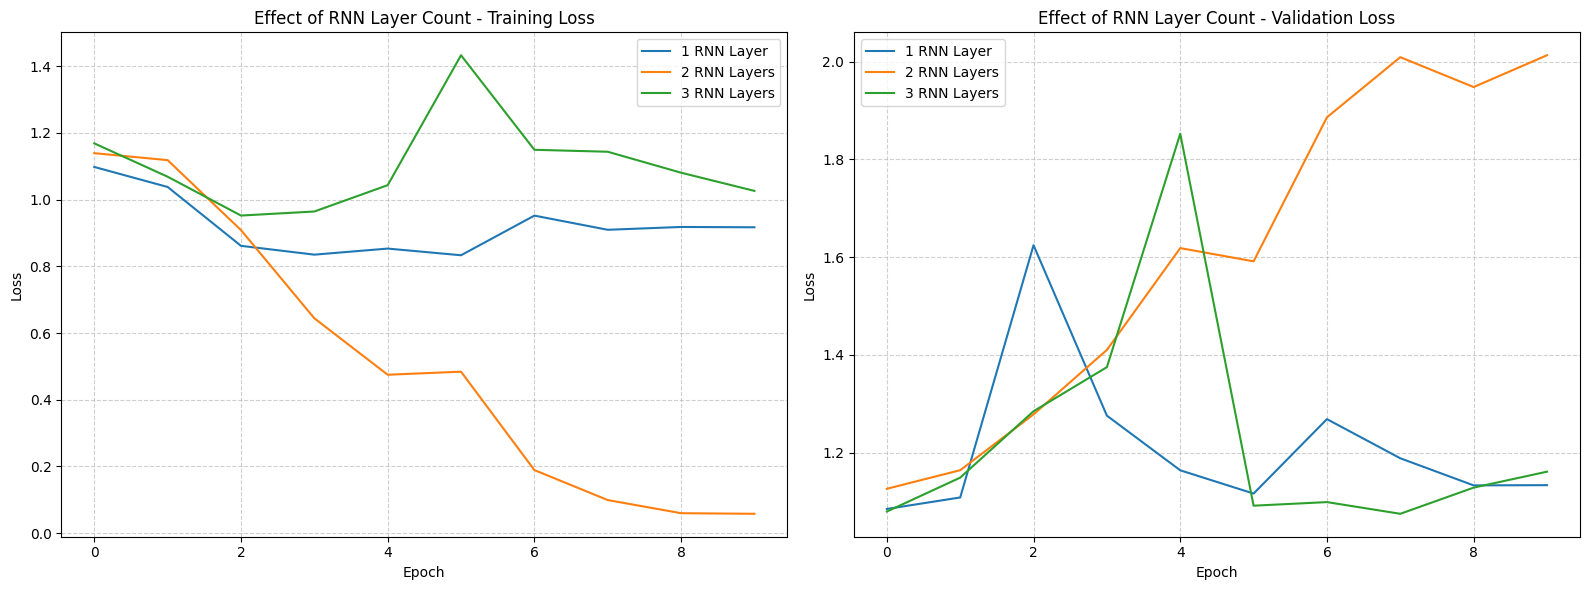

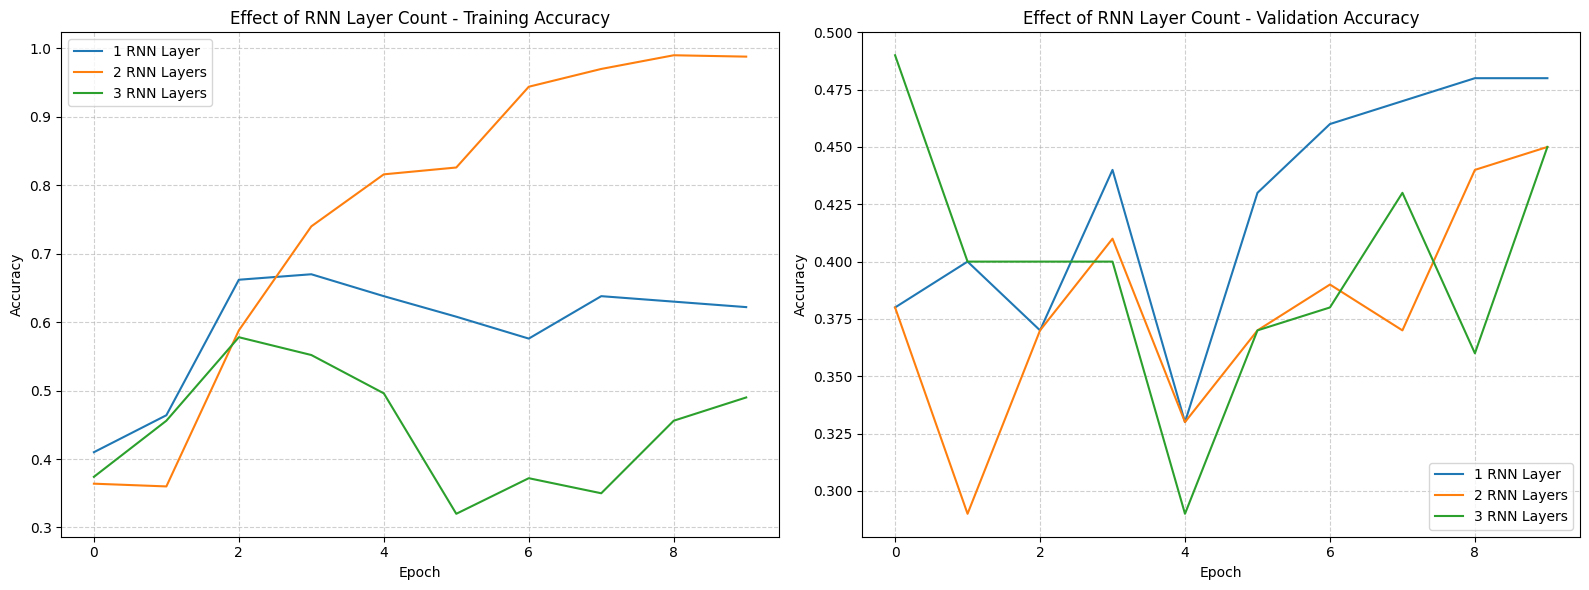

In [29]:
layer_count_variants = [
    (1, "1 RNN Layer"),
    (2, "2 RNN Layers"),
    (3, "3 RNN Layers")
]

# Run experiment
layer_count_models, layer_count_histories = experiments.run_layer_count_experiment(layer_count_variants)

### 2.2 Experiment: Number of RNN Cells per Layer


=== Training model with 32 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.4476 - loss: 1.0572 - val_accuracy: 0.5100 - val_loss: 1.0224
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6483 - loss: 0.8012 - val_accuracy: 0.4200 - val_loss: 1.2117
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6348 - loss: 0.8699 - val_accuracy: 0.5700 - val_loss: 0.9928
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.7076 - loss: 0.6549 - val_accuracy: 0.4400 - val_loss: 1.2355
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7129 - loss: 0.6291 - val_accuracy: 0.5100 - val_loss: 1.1437
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7227 - loss: 0.5355 - val_accuracy: 0.4200 - val_loss: 1.4961
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7238 - loss: 0.5806 - val_accuracy: 0.3100 - val_loss: 1.7861
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7052 - loss: 0.6101 - val_accuracy: 0.2900 - val_loss: 

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 32)             │         4,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,867 (3.30 MB)

 Trainable params: 287,955 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 575,912 (2.20 MB)


=== Training model with 64 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.3368 - loss: 1.1212 - val_accuracy: 0.3800 - val_loss: 1.0872
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3938 - loss: 1.0810 - val_accuracy: 0.4700 - val_loss: 1.0531
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5701 - loss: 0.9107 - val_accuracy: 0.4400 - val_loss: 1.1081
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6358 - loss: 0.8513 - val_accuracy: 0.4200 - val_loss: 1.2170
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7288 - loss: 0.7247 - val_accuracy: 0.4300 - val_loss: 1.2214
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5871 - loss: 0.8898 - val_accuracy: 0.4700 - val_loss: 1.1565
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3807 - loss: 1.1692 - val_accuracy: 0.4200 - val_loss: 1.1322
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7843 - loss: 0.7364 - val_accuracy: 0.4000 - val_loss: 1

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_18 (SimpleRNN)       │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,067 (3.37 MB)

 Trainable params: 294,355 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,712 (2.25 MB)


=== Training model with 128 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.3933 - loss: 1.1145 - val_accuracy: 0.3400 - val_loss: 1.1040
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3726 - loss: 1.1274 - val_accuracy: 0.3700 - val_loss: 1.0804
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4589 - loss: 1.0936 - val_accuracy: 0.4400 - val_loss: 1.0906
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5145 - loss: 1.0329 - val_accuracy: 0.3300 - val_loss: 1.1497
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2747 - loss: 1.2617 - val_accuracy: 0.3800 - val_loss: 1.1458
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5104 - loss: 1.0051 - val_accuracy: 0.3100 - val_loss: 1.2848
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3025 - loss: 1.3124 - val_accuracy: 0.3400 - val_loss: 1.1157
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3557 - loss: 1.1488 - val_accuracy: 0.3600 - val_loss: 1

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_19 (SimpleRNN)       │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,899 (3.59 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,600 (2.39 MB)

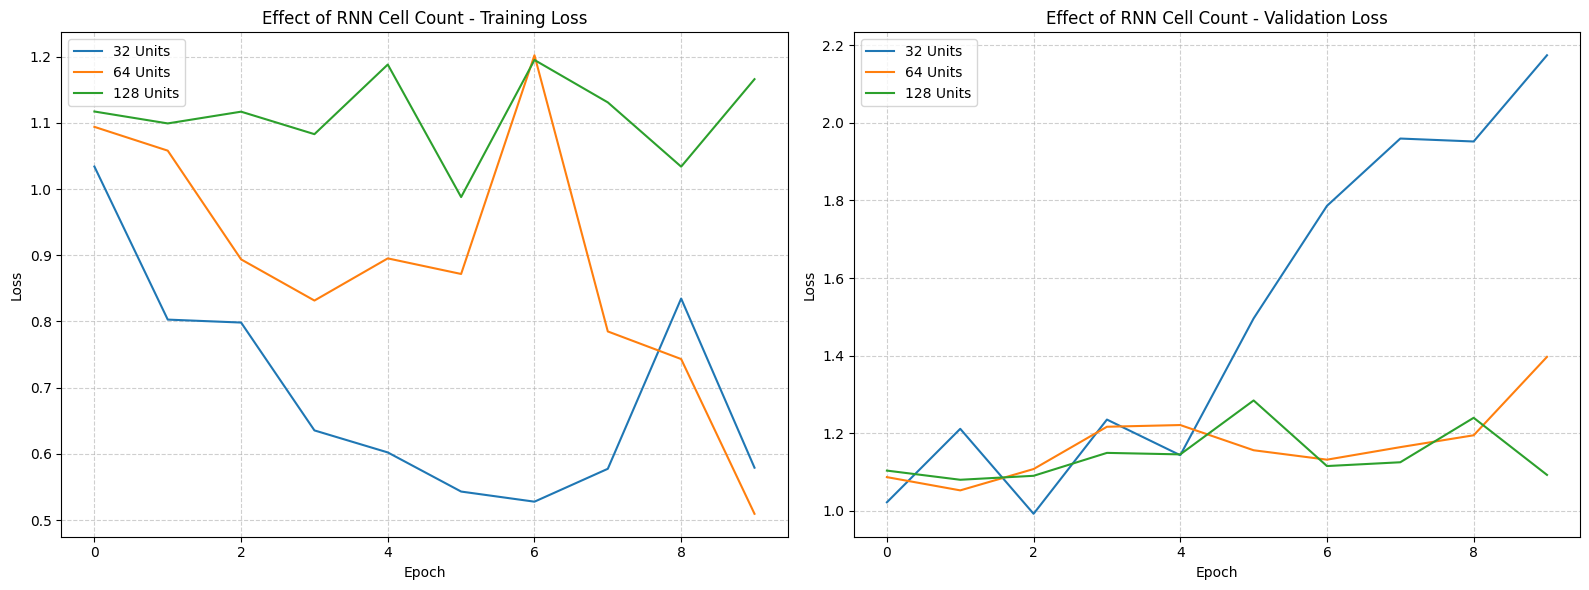

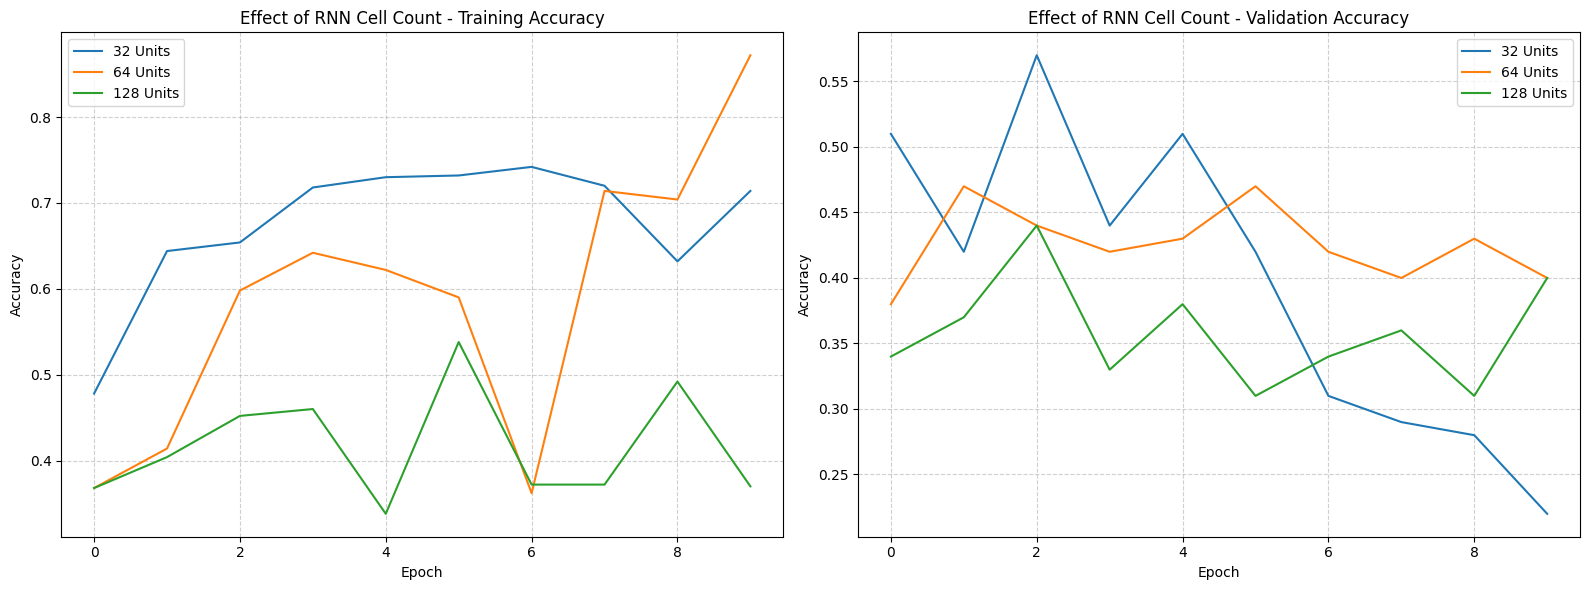

In [19]:
# Define variants for cell counts
cell_count_variants = [
    ([32], "32 Units"),
    ([64], "64 Units"),
    ([128], "128 Units")
]

# Run experiment
cell_count_models, cell_count_histories = experiments.run_cell_count_experiment(cell_count_variants)

### 2.3 Experiment: RNN Direction


=== Training model with Unidirectional RNN RNN ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4232 - loss: 1.0935 - val_accuracy: 0.2200 - val_loss: 1.1190
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3359 - loss: 1.1254 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3216 - loss: 1.1511 - val_accuracy: 0.3800 - val_loss: 1.1184
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3257 - loss: 1.1635 - val_accuracy: 0.3800 - val_loss: 1.0909
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3254 - loss: 1.1617 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3825 - loss: 1.0982 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4010 - loss: 1.0878 - val_accuracy: 0.3800 - val_loss: 1.0821
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3391 - loss: 1.1042 - val_accuracy: 0.3800 - val_loss: 1

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_20 (SimpleRNN)       │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,899 (3.59 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,600 (2.39 MB)


=== Training model with Bidirectional RNN RNN ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.4123 - loss: 1.0667 - val_accuracy: 0.3900 - val_loss: 1.1225
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5414 - loss: 0.8699 - val_accuracy: 0.5100 - val_loss: 0.9742
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7573 - loss: 0.6497 - val_accuracy: 0.4800 - val_loss: 1.0644
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9435 - loss: 0.3336 - val_accuracy: 0.3600 - val_loss: 1.7989
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8574 - loss: 0.3050 - val_accuracy: 0.4200 - val_loss: 1.2905
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9702 - loss: 0.1290 - val_accuracy: 0.4700 - val_loss: 1.2882
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9844 - loss: 0.0724 - val_accuracy: 0.4000 - val_loss: 1.5202
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9982 - loss: 0.0398 - val_accuracy: 0.4500 - val_loss: 1

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │        58,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,987 (3.93 MB)

 Trainable params: 342,995 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 685,992 (2.62 MB)

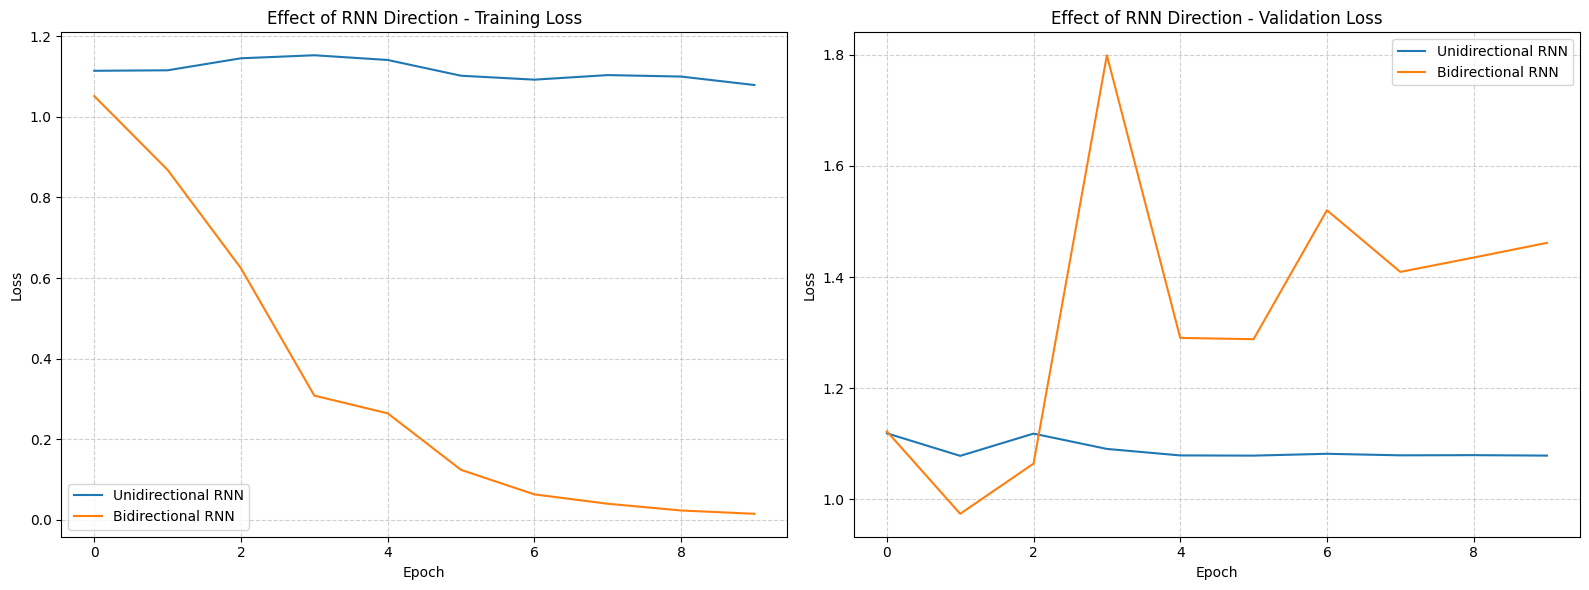

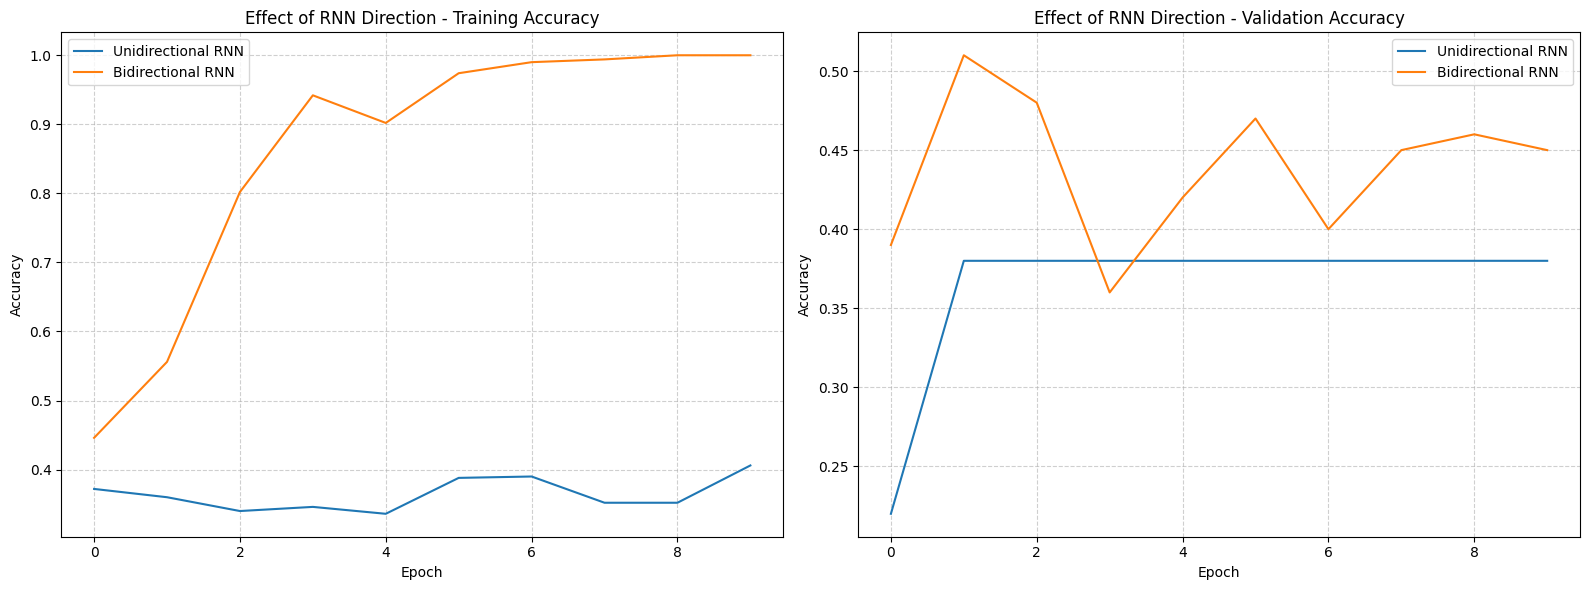

In [20]:
# Define variants for RNN direction
direction_variants = [
    (False, "Unidirectional RNN"),
    (True, "Bidirectional RNN")
]

# Run experiment
direction_models, direction_histories = experiments.run_direction_experiment(direction_variants)

## 3. From-Scratch RNN Implementation

In [21]:
# Choose one of the trained models (e.g., from the bidirectional experiment)
keras_model_path = "../../output/models/rnn/rnn_bidirectional.keras"
if os.path.exists(keras_model_path):
    keras_model = load_model(keras_model_path)
elif len(direction_models) > 1 and direction_models[1][0] is not None:
    keras_model = direction_models[1][0]  # Bidirectional RNN model
else:
    keras_model = direction_models[0][0]  # Unidirectional RNN model

# Summary of the chosen model
keras_model.summary()

# Save the model weights
keras_model.save_weights('../output/models/rnn/rnn_model.weights.h5')

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │        58,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,987 (3.93 MB)

 Trainable params: 342,995 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 685,992 (2.62 MB)

In [22]:
# Get embedding dimension and vocabulary size
embedding_dim = 100
vocab_size = len(data_loader.get_vocabulary())
hidden_dim = 128
num_classes = data_loader.num_classes
sequence_length = data_loader.max_sequence_length
bidirectional = True  # Set this based on the chosen model

# Create a from-scratch RNN model that matches the Keras model
scratch_model = RNNModel()

# Add layers corresponding to the Keras model architecture
scratch_model.add(EmbeddingLayer(input_dim=vocab_size, output_dim=embedding_dim))
scratch_model.add(RNNLayer(input_dim=embedding_dim, hidden_dim=hidden_dim, bidirectional=bidirectional, return_sequences=False))
scratch_model.add(DropoutLayer(dropout_rate=0.2))
scratch_model.add(DenseLayer(input_dim=hidden_dim*2 if bidirectional else hidden_dim, output_dim=num_classes))
scratch_model.add(Softmax())

# Load weights from the Keras model
scratch_model.load_weights_from_keras(keras_model)

print("Weights loaded from Keras model to from-scratch implementation.")

Loading weights from Keras model...
Keras model has 4 layers
Scratch model has 5 layers

Keras model architecture:
  Layer 0: Embedding -> Unknown
  Layer 1: Bidirectional -> Unknown
  Layer 2: Dropout -> Unknown
  Layer 3: Dense -> Unknown

Scratch model architecture:
  Layer 0: EmbeddingLayer
  Layer 1: RNNLayer
  Layer 2: DropoutLayer
  Layer 3: DenseLayer
  Layer 4: Softmax

Loading weights for layer 0:
Successfully loaded weights for layer 0

Loading weights for layer 1:
Loaded weights - W: (100, 128), U: (128, 128), b: (128,)
Backward weights - W: (100, 128), U: (128, 128), b: (128,)
Successfully loaded weights for layer 1

Loading weights for layer 2:
Successfully loaded weights for layer 2

Loading weights for layer 3:
Successfully loaded weights for layer 3

✅ Successfully loaded weights for 4/5 layers
Weights loaded from Keras model to from-scratch implementation.


In [23]:
# Get test data
x_test, y_test = data_loader.get_vectorized_data('test')

# Compare predictions
comparison = compare_keras_vs_scratch(keras_model, scratch_model, x_test, y_test, batch_size=32)

print("\nKeras Model Metrics:")
print(f"Accuracy: {comparison['keras_metrics']['accuracy']:.4f}")
print(f"Macro F1-Score: {comparison['keras_metrics']['macro_f1']:.4f}")

print("\nFrom-Scratch Model Metrics:")
print(f"Accuracy: {comparison['scratch_metrics']['accuracy']:.4f}")
print(f"Macro F1-Score: {comparison['scratch_metrics']['macro_f1']:.4f}")

print(f"\nModel Agreement: {comparison['model_agreement']:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Layer 0 (EmbeddingLayer): (1, 100) -> (1, 100, 100)
Layer 1 (RNNLayer): (1, 100, 100) -> (1, 256)
Layer 2 (DropoutLayer): (1, 256) -> (1, 256)
Layer 3 (DenseLayer): (1, 256) -> (1, 3)
Layer 4 (Softmax): (1, 3) -> (1, 3)
Layer 0 (EmbeddingLayer): (1, 100) -> (1, 100, 100)
Layer 1 (RNNLayer): (1, 100, 100) -> (1, 256)
Layer 2 (DropoutLayer): (1, 256) -> (1, 256)
Layer 3 (DenseLayer): (1, 256) -> (1, 3)
Layer 4 (Softmax): (1, 3) -> (1, 3)
Layer 0 (EmbeddingLayer): (1, 100) -> (1, 100, 100)
Layer 1 (RNNLayer): (1, 100, 100) -> (1, 256)
Layer 2 (DropoutLayer): (1, 256) -> (1, 256)
Layer 3 (DenseLayer): (1, 256) -> (1, 3)
Layer 4 (Softmax): (1, 3) -> (1, 3)
Layer 0 (EmbeddingLayer): (1, 100) -> (1, 100, 100)
Layer 1 (RNNLayer): (1, 100, 100) -> (1, 256)
Layer 2 (DropoutLayer): (1, 256) -> (1, 256)
Layer 3 (DenseLayer): (1, 256) -> (1, 3)
Layer 4 (Softmax): (1, 3) -> (1, 3)
Layer 0 (EmbeddingLayer): (1, 100) -> (1, 100, 100)
Layer 1 (RNNLayer): (1, 100,

In [24]:
# Get a few test samples
num_samples = 5
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
sample_texts = x_test[sample_indices]
sample_labels = y_test[sample_indices]

# Make predictions with both models
keras_preds = np.argmax(keras_model.predict(sample_texts), axis=1)
scratch_preds = scratch_model.predict(sample_texts)

# Define sentiment labels
sentiment_labels = ["Negative", "Neutral", "Positive"]

# Visualize the results
for i in range(num_samples):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_texts[i] if idx > 0]
    text = " ".join(words)
    
    # Show true label and predictions
    keras_correct = keras_preds[i] == sample_labels[i]
    scratch_correct = scratch_preds[i] == sample_labels[i]
    
    print(f"\nText: {text[:100]}{'...' if len(text) > 100 else ''}")
    print(f"True sentiment: {sentiment_labels[sample_labels[i]]}")
    print(f"Keras prediction: {sentiment_labels[keras_preds[i]]} {'✓' if keras_correct else '✗'}")
    print(f"Scratch prediction: {sentiment_labels[scratch_preds[i]]} {'✓' if scratch_correct else '✗'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Layer 0 (EmbeddingLayer): (1, 100) -> (1, 100, 100)
Layer 1 (RNNLayer): (1, 100, 100) -> (1, 256)
Layer 2 (DropoutLayer): (1, 256) -> (1, 256)
Layer 3 (DenseLayer): (1, 256) -> (1, 3)
Layer 4 (Softmax): (1, 3) -> (1, 3)
Layer 0 (EmbeddingLayer): (1, 100) -> (1, 100, 100)
Layer 1 (RNNLayer): (1, 100, 100) -> (1, 256)
Layer 2 (DropoutLayer): (1, 256) -> (1, 256)
Layer 3 (DenseLayer): (1, 256) -> (1, 3)
Layer 4 (Softmax): (1, 3) -> (1, 3)
Layer 0 (EmbeddingLayer): (1, 100) -> (1, 100, 100)
Layer 1 (RNNLayer): (1, 100, 100) -> (1, 256)
Layer 2 (DropoutLayer): (1, 256) -> (1, 256)
Layer 3 (DenseLayer): (1, 256) -> (1, 3)
Layer 4 (Softmax): (1, 3) -> (1, 3)
Layer 0 (EmbeddingLayer): (1, 100) -> (1, 100, 100)
Layer 1 (RNNLayer): (1, 100, 100) -> (1, 256)
Layer 2 (DropoutLayer): (1, 256) -> (1, 256)
Layer 3 (DenseLayer): (1, 256) -> (1, 3)
Layer 4 (Softmax): (1, 3) -> (1, 3)
Layer 0 (EmbeddingLayer): (1, 100) -> (1, 100, 100)
Layer 1 (RNNLayer): (1, 100, 

## 4. Additional Experiments: Multi-layer RNN Models

In [25]:
# Ensure output directories exist
os.makedirs("../../output/models/rnn", exist_ok=True)
os.makedirs("../../output/results/rnn", exist_ok=True)

In [26]:
# Load models from previously saved files
model_paths = {
    "1_layer": "../output/models/rnn/rnn_layers_1.keras",
    "2_layer": "../output/models/rnn/rnn_layers_2.keras",
    "3_layer": "../output/models/rnn/rnn_layers_3.keras"
}

loaded_models = {}

for name, path in model_paths.items():
    if os.path.exists(path):
        print(f"Loading model: {name}")
        loaded_models[name] = load_model(path)
        loaded_models[name].summary()
    else:
        print(f"Model file not found: {path}")

Loading model: 1_layer


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,067 (3.37 MB)

 Trainable params: 294,355 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,712 (2.25 MB)

Loading model: 2_layer


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,835 (3.46 MB)

 Trainable params: 302,611 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 605,224 (2.31 MB)

Loading model: 3_layer


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ (None, 100, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 932,603 (3.56 MB)

 Trainable params: 310,867 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 621,736 (2.37 MB)

In [27]:
# Compare the multi-layer models
results = {}

for name, path in model_paths.items():
    if not os.path.exists(path):
        print(f"Model file not found: {path}")
        continue
        
    print(f"\nBuilding and comparing {name} model...")
    
    # Create a matching from-scratch model for each Keras model
    try:
        comparison_result = experiments.compare_models(keras_model_path=path)
        
        # Store the results
        results[name] = comparison_result
        
        # Print key metrics
        print("\nComparison Results:")
        print(f"Keras Accuracy: {comparison_result['keras_metrics']['accuracy']:.4f}")
        print(f"Scratch Accuracy: {comparison_result['scratch_metrics']['accuracy']:.4f}")
        print(f"Model Agreement: {comparison_result['model_agreement']:.4f}")
        
    except Exception as e:
        print(f"Error processing model {name}: {e}")
        import traceback
        traceback.print_exc()


Building and comparing 1_layer model...
Loaded Keras model from ../output/models/rnn/rnn_layers_1.keras


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,067 (3.37 MB)

 Trainable params: 294,355 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,712 (2.25 MB)

Keras model has 4 layers
Processing layer 0: Embedding
Added Embedding layer: 2836 → 100
Processing layer 1: SimpleRNN
Added RNN layer: 100 → 64 (return_sequences=False)
Processing layer 2: Dropout
Added Dropout layer: rate=0.2
Processing layer 3: Dense
Added Dense layer: 64 → 3
Added Softmax activation

Scratch model structure:
Layer 0: EmbeddingLayer
Layer 1: RNNLayer
Layer 2: DropoutLayer
Layer 3: DenseLayer
Layer 4: Softmax
Loading weights from Keras model...
Keras model has 4 layers
Scratch model has 5 layers

Keras model architecture:
  Layer 0: Embedding -> Unknown
  Layer 1: SimpleRNN -> Unknown
  Layer 2: Dropout -> Unknown
  Layer 3: Dense -> Unknown

Scratch model architecture:
  Layer 0: EmbeddingLayer
  Layer 1: RNNLayer
  Layer 2: DropoutLayer
  Layer 3: DenseLayer
  Layer 4: Softmax

Loading weights for layer 0:
Successfully loaded weights for layer 0

Loading weights for layer 1:
Loaded weights - W: (100, 64), U: (64, 64), b: (64,)
Successfully loaded weights for layer 

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,835 (3.46 MB)

 Trainable params: 302,611 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 605,224 (2.31 MB)

Keras model has 6 layers
Processing layer 0: Embedding
Added Embedding layer: 2836 → 100
Processing layer 1: SimpleRNN
Added RNN layer: 100 → 64 (return_sequences=True)
Processing layer 2: Dropout
Added Dropout layer: rate=0.2
Processing layer 3: SimpleRNN
Added RNN layer: 100 → 64 (return_sequences=False)
Processing layer 4: Dropout
Added Dropout layer: rate=0.2
Processing layer 5: Dense
Added Dense layer: 64 → 3
Added Softmax activation

Scratch model structure:
Layer 0: EmbeddingLayer
Layer 1: RNNLayer
Layer 2: DropoutLayer
Layer 3: RNNLayer
Layer 4: DropoutLayer
Layer 5: DenseLayer
Layer 6: Softmax
Loading weights from Keras model...
Keras model has 6 layers
Scratch model has 7 layers

Keras model architecture:
  Layer 0: Embedding -> Unknown
  Layer 1: SimpleRNN -> Unknown
  Layer 2: Dropout -> Unknown
  Layer 3: SimpleRNN -> Unknown
  Layer 4: Dropout -> Unknown
  Layer 5: Dense -> Unknown

Scratch model architecture:
  Layer 0: EmbeddingLayer
  Layer 1: RNNLayer
  Layer 2: Dropo

Traceback (most recent call last):
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/experiment.py", line 433, in compare_models
    comparison = compare_keras_vs_scratch(keras_model, scratch_model, x_test, y_test, batch_size=self.batch_size)
  File "/root/ML/src/notebooks/../../src/models/src/models/base_model/utils/evaluation.py", line 20, in compare_keras_vs_scratch
    scratch_preds = scratch_model.predict(x_test)
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/rnn_model.py", line 40, in predict
    batch_outputs = self.forward(batch_inputs)
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/rnn_model.py", line 26, in forward
    raise e
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/rnn_model.py", line 20, in forward
    x = layer.forward(x)
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/rnn_layer.py", line 48, in forward
    raise ValueError(f"Input dim mismatch: expected {self.input_dim}, got {actual_input_d

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ (None, 100, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 932,603 (3.56 MB)

 Trainable params: 310,867 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 621,736 (2.37 MB)

Keras model has 8 layers
Processing layer 0: Embedding
Added Embedding layer: 2836 → 100
Processing layer 1: SimpleRNN
Added RNN layer: 100 → 64 (return_sequences=True)
Processing layer 2: Dropout
Added Dropout layer: rate=0.2
Processing layer 3: SimpleRNN
Added RNN layer: 100 → 64 (return_sequences=True)
Processing layer 4: Dropout
Added Dropout layer: rate=0.2
Processing layer 5: SimpleRNN
Added RNN layer: 100 → 64 (return_sequences=False)
Processing layer 6: Dropout
Added Dropout layer: rate=0.2
Processing layer 7: Dense
Added Dense layer: 64 → 3
Added Softmax activation

Scratch model structure:
Layer 0: EmbeddingLayer
Layer 1: RNNLayer
Layer 2: DropoutLayer
Layer 3: RNNLayer
Layer 4: DropoutLayer
Layer 5: RNNLayer
Layer 6: DropoutLayer
Layer 7: DenseLayer
Layer 8: Softmax
Loading weights from Keras model...
Keras model has 8 layers
Scratch model has 9 layers

Keras model architecture:
  Layer 0: Embedding -> Unknown
  Layer 1: SimpleRNN -> Unknown
  Layer 2: Dropout -> Unknown
  L

Traceback (most recent call last):
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/experiment.py", line 433, in compare_models
    comparison = compare_keras_vs_scratch(keras_model, scratch_model, x_test, y_test, batch_size=self.batch_size)
  File "/root/ML/src/notebooks/../../src/models/src/models/base_model/utils/evaluation.py", line 20, in compare_keras_vs_scratch
    scratch_preds = scratch_model.predict(x_test)
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/rnn_model.py", line 40, in predict
    batch_outputs = self.forward(batch_inputs)
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/rnn_model.py", line 26, in forward
    raise e
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/rnn_model.py", line 20, in forward
    x = layer.forward(x)
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/rnn_layer.py", line 48, in forward
    raise ValueError(f"Input dim mismatch: expected {self.input_dim}, got {actual_input_d

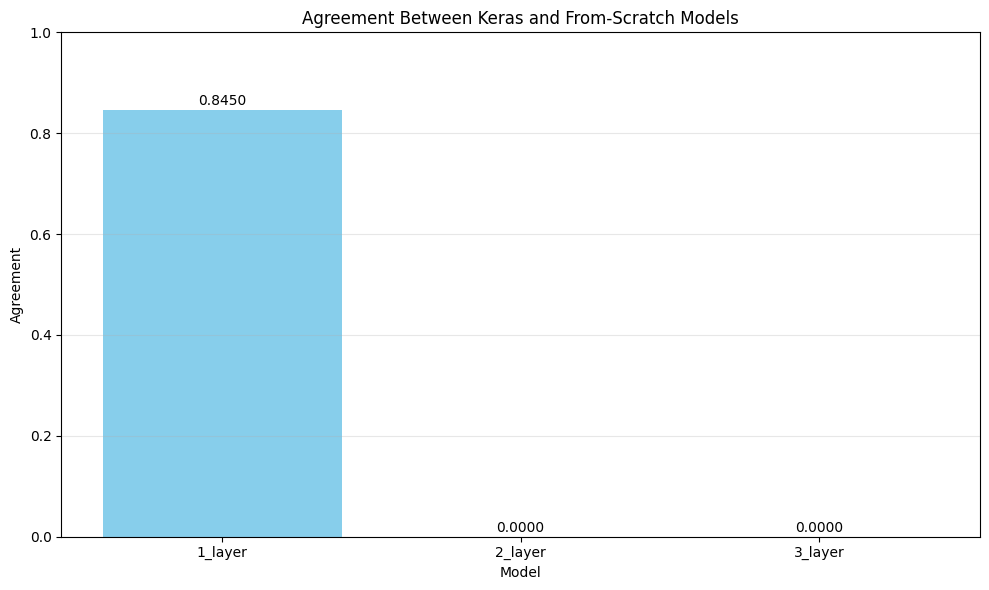

In [28]:
# Visualize agreement between Keras and from-scratch models
if results:
    model_names = list(results.keys())
    agreements = [results[name]['model_agreement'] for name in model_names]
    
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, agreements, color='skyblue')
    plt.title('Agreement Between Keras and From-Scratch Models')
    plt.xlabel('Model')
    plt.ylabel('Agreement')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    
    # Add agreement values on top of bars
    for i, v in enumerate(agreements):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.savefig('../../output/results/rnn/model_agreement.png')
    plt.show()